In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
FILE_PATH = Path("/mnt/c/Users/rshdk/Documents/hds/remote-proj/dissertation-proj-files/files/cxr-lt-2023/train.csv")
df = pd.read_csv(FILE_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264849 entries, 0 to 264848
Data columns (total 32 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   dicom_id                      264849 non-null  object
 1   subject_id                    264849 non-null  int64 
 2   study_id                      264849 non-null  int64 
 3   ViewPosition                  253799 non-null  object
 4   ViewCodeSequence_CodeMeaning  253323 non-null  object
 5   path                          264849 non-null  object
 6   Atelectasis                   264849 non-null  int64 
 7   Calcification of the Aorta    264849 non-null  int64 
 8   Cardiomegaly                  264849 non-null  int64 
 9   Consolidation                 264849 non-null  int64 
 10  Edema                         264849 non-null  int64 
 11  Emphysema                     264849 non-null  int64 
 12  Enlarged Cardiomediastinum    264849 non-null  int64 
 13 

ViewPosition
AP                103312
PA                 67559
LATERAL            58018
LL                 24894
PA LLD                 4
LAO                    3
RAO                    3
AP AXIAL               2
XTABLE LATERAL         1
AP LLD                 1
PA RLD                 1
AP RLD                 1
Name: count, dtype: int64


<Axes: xlabel='ViewPosition'>

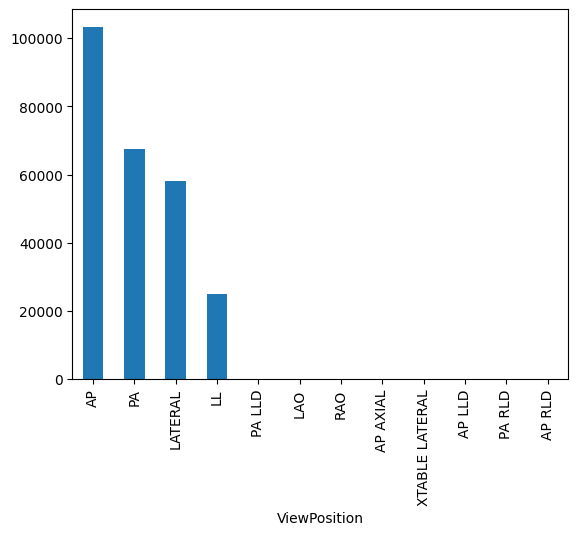

In [24]:
print(df["ViewPosition"].value_counts())

# view_count = pd.DataFrame({
#     "Frontal": df["ViewPosition"][df["ViewPosition"].str.contains("AP") | df["ViewPosition"].str.contains("PA")].count(),
#     "Lateral": df["ViewPosition"][df["ViewPosition"].str.contains("Lateral") | df["ViewPosition"].str.contains("LL")].count(),
# })
# plt.bar(
#     ["Frontal", "Lateral"],
#     view_count.iloc[0],
# )
df["ViewPosition"].value_counts().plot(kind="bar")